In [1]:
import math
import numpy as np
from tqdm import tqdm
import torch
import pickle

from helpers.data import get_pdf_toy, read_in_data
from helpers.ansatz import q

import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot, hist_with_errors, hist_with_errors

In [2]:
device = "cpu"

In [16]:
outfile_name = f"angularity_2_test"


with open(f"data/{outfile_name}", "rb") as ifile:
    save_dict = pickle.load(ifile)
    
distribution = save_dict["configs"]["distribution"]
order_to_match = save_dict["configs"]["order_to_match"]
name = save_dict["configs"]["name"]
mstar = save_dict["configs"]["mstar"]



print(save_dict["configs"])

titles = {"LO_thrust" : r"Thrust @ " + r"$\mathcal{O}(\alpha_s^" + str(1) + "$)\t\t\t\t\t",
          "angularity" : r"Pseudo-Angularity @ " + r"$\mathcal{O}(\alpha_s^" + str(2) + "$)\t\t\t\t\t",
        }

ylims = {"LO_thrust" : (-1.5, 1.1),
         "angularity" : (-0.5, 1.1),
}

run_toy = not ("thrust" in outfile_name)
print(f"Running toy: {run_toy}")


{'distribution': 'angularity', 'order_to_match': 2, 'name': 'test', 'mstar': 1, 'init_random': True, 'init_at_answer': False, 'init_close_to_answer': False, 'learn_theta': False, 'ratio_loss': False, 'use_logbins': False, 'n_bins': 100, 't_min': 0, 't_max': 10, 'epochs': 20000, 'batch_size': 512, 'lr': 0.01, 'seed': 42, 'm': 3, 'n': 3}
Running toy: True


In [4]:
# load in data


losses = save_dict["loss"]
g_coeffs_log = save_dict["g_coeffs"]
theta_log = save_dict["theta"]



In [5]:
# Helper functions ofr plotting

max_M, max_N = g_coeffs_log[0].shape


factorial_cache_n = torch.tensor([math.factorial(k) for k in range(max_N)], device=device).float()
factorial_cache_m = torch.tensor([math.factorial(k) for k in range(max_M)], device=device).float()
n_range = torch.arange(max_N, device=device)
m_range = torch.arange(1, max_M, device=device)

factorial_cache_info = factorial_cache_m, factorial_cache_n, m_range, n_range



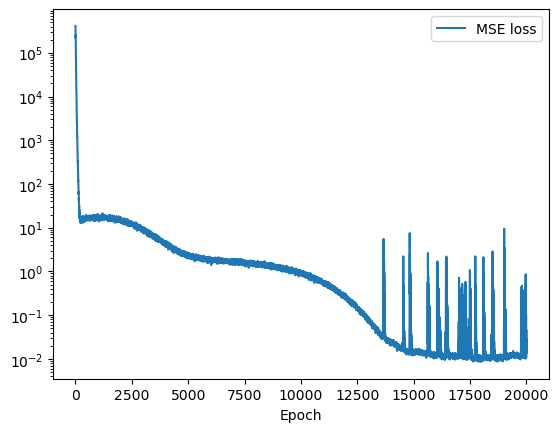

In [6]:


# Plot loss
plt.figure()
plt.plot(losses, label="MSE loss")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.show()



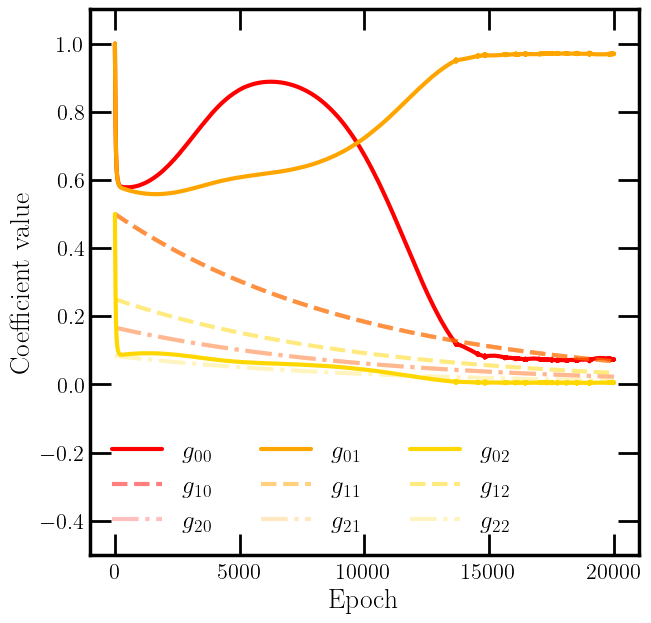

In [7]:


from matplotlib.pyplot import cm
color = iter(cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[2]+1)))
opacities = [1.0, 0.5, 0.25]
linestyles = ["-", "--", "-."]

colors = ["red", "orange", "gold"]

fig, ax = newplot('full')
for n in range(g_coeffs_log.shape[2]):
    c = colors[n]
    for m in range(g_coeffs_log.shape[1]):
        label = f"$g_{{{m}{n}}}$"
        plt.plot(g_coeffs_log[:, m, n], label=label, color=c, alpha=opacities[m], linestyle=linestyles[m])
plt.legend(ncol = 3)#, title = "Thrust @ " + r"$\mathcal{O}(\alpha_s^" + str(order_to_match) + "$)\t\t\t\t\t")
plt.xlabel("Epoch")
plt.ylabel("Coefficient value")
plt.ylim(ylims[distribution])
plt.savefig(f"figures/{outfile_name}_coeffs_nice.png", bbox_inches = "tight")

plt.show()



In [17]:
def read_in_data(file_indices, example, t_bins, device):

    if example == "LO_thrust":
        example = "thrust"

    from sklearn.preprocessing import MinMaxScaler

    data_dict = {}
    bin_width = t_bins.detach().cpu().numpy()[1] - t_bins.detach().cpu().numpy()[0]

    for i in file_indices:
        with open(f"event_records_LO_{i}.pkl", "rb") as ifile:
            loc_data_dict = pickle.load(ifile)
            for alpha in loc_data_dict.keys():

                loc_data = loc_data_dict[alpha][example]
                if example == "thrust":
                    loc_data = [2.0 * (1.0 - x) for x in loc_data]

                # scaler = MinMaxScaler()
                # loc_data = scaler.fit_transform(np.array(loc_data).reshape(-1,1))

                # convert to t-space
                loc_data = [np.log(1.0 / (x + 1e-12)) for x in loc_data]

                y, _ = np.histogram(
                    loc_data,
                    weights=loc_data_dict[alpha]["weight"],
                    bins=t_bins.detach().cpu().numpy(),
                    density=False,
                )
                y /= bin_width
                y = torch.tensor(y, device=device).reshape(-1, 1)
                data_dict[alpha] = y.squeeze(0).float()

    return data_dict

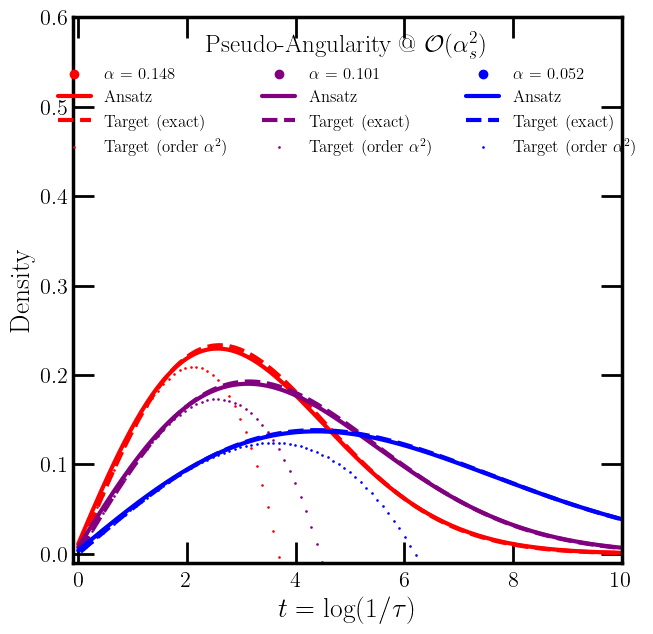

In [ ]:



if save_dict["configs"]["use_logbins"]:
    t_bins = torch.logspace(
        np.log10(save_dict["configs"]["t_min"]), np.log10(save_dict["configs"]["t_max"]), save_dict["configs"]["n_bins"], device=device
    )
    t_bin_centers = torch.sqrt((t_bins[1:] * t_bins[:-1]))
else:
    t_bins = torch.linspace(save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], save_dict["configs"]["n_bins"], device=device)
    t_bin_centers = 0.5 * (t_bins[1:] + t_bins[:-1])


if not run_toy:  # only needs to be done once
    data_dict = read_in_data([2], distribution, t_bins, device)
    #print(data_dict.keys())



tt = torch.linspace(save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], 200, device=device)


colors = ["red", "purple", "blue"]


fig, ax = newplot("full")

for i, alpha in enumerate([0.148, 0.101, 0.052]):
    alpha_tensor = torch.tensor(alpha, device=device)
    plt.scatter( 100, 100, label=f"$\\alpha$ = {alpha}",  color=colors[i])



    plt.plot(  
       tt.detach().cpu().numpy(),q(tt, alpha_tensor, torch.tensor(g_coeffs_log[-1]).to(device), torch.tensor(theta_log[-1]).to(device), save_dict["configs"]["mstar"], save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], device, factorial_cache_info), label="Ansatz",  color=colors[i],
    )

    if run_toy:
        plt.plot(
            t_bin_centers.detach().cpu().numpy(),
            get_pdf_toy( alpha_tensor, distribution, t_bin_centers, -1, device).detach().cpu().numpy(), label="Exact Sol.", color=colors[i],  linestyle="dashed",
        )
        plt.scatter(
            t_bin_centers.detach().cpu().numpy(),get_pdf_toy(alpha_tensor, distribution, t_bin_centers,order_to_match,device) .detach().cpu() .numpy(), label=f"Target (order $\\alpha^{order_to_match}$)",  color=colors[i],  s=0.8,
        )

    else:
        alpha_string = "alpha_" + str(int(1000 * alpha)).zfill(4)
        plt.plot(t_bin_centers.detach().cpu().numpy(),data_dict[alpha_string].detach().cpu().numpy(),label="Target (MG5)",color=colors[i], linestyle="dotted",)
        plt.plot(tt.detach().cpu().numpy(),get_pdf_toy(alpha_tensor, "LO_thrust", tt, -1, device).detach() .cpu().numpy(),label="Leading Log", color=colors[i],linestyle="dashed",
        )
plt.legend(loc = "upper center", ncol = 3, fontsize = 12, title = titles[distribution])
plt.xlabel(r"$t = \log(1/\tau)$")
plt.ylabel("Density")
plt.xlim(-0.1, 10)
plt.ylim(-0.01, 0.6)
plt.savefig(f"figures/{outfile_name}_results_nice.png", bbox_inches = "tight")

plt.show()

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
with open("event_records_LO_1.pkl", "rb") as ifile:
    data = pickle.load(ifile)
print(data.keys())


#print(data["alpha_0053"]["weight"])



In [ ]:

x_0 = data["alpha_0197"]["c_parameter"]
x_1 = data["alpha_0460"]["c_parameter"]

loc_data_0 = [np.log(1.0 / (x + 1e-12)) for x in x_0]
loc_data_1 = [np.log(1.0 / (x + 1e-12)) for x in x_1]

bins =  np.linspace(0, 10, 20)

bin_width = bins[1] - bins[0]

#loc_data = [np.log(1.0 / ((2*(1-x)) + 1e-12)) for x in x]

plt.figure()


y_0, _ = np.histogram(loc_data_0, weights = data["alpha_0197"]["weight"], bins = bins)
y_1, _ = np.histogram(loc_data_1, weights = data["alpha_0460"]["weight"], bins = bins)

plt.step(bins[1:], y_0/bin_width)
plt.step(bins[1:], y_1/bin_width)

#plt.yscale("log")
plt.show()

In [ ]:

def f_toy(t, alpha):
    pstar =  (6*torch.exp(-y) + (4 / (1 - torch.exp(-y))))*torch.log((1 - 2*torch.exp(-y))/torch.exp(-y)) - 3 + 6*torch.exp(-y) + 9*torch.exp(-2*y)
    return  alpha* (4/3) * pstar / (2*np.pi)


tmin = 0
tmax = 10




t_bins = torch.linspace(tmin, tmax, 100)

qq = q(t_bin_centers, 0.1)


plt.figure()
plt.plot(t_bin_centers.detach().cpu().numpy(), qq.detach().cpu().numpy())
plt.xlabel("t")
plt.show()

In [ ]:
alpha = 0.1

y = alpha* (4/3) * (1.0 / (2*np.pi)) * (4*t_bin_centers - 3)*torch.exp(alpha* (4/3) * (1.0 / (2*np.pi))*(2*torch.pow(t_bin_centers, 2) -3*t_bin_centers))
